In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

import os

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from torchvision.models import ResNet18_Weights

In [2]:
import torch

if torch.cuda.is_available():
    print(f"Notebook is running on GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Notebook is running on CPU")


Notebook is running on CPU


In [5]:
import umap

## Structured approach to apply GMM to cluster heatmaps

 - **1. Flatten Heatmaps and Apply GMM Directly:**
 Flattening the heatmaps would convert each [64, 64] heatmap into a vector of size 4096. This would result in a data matrix of shape [491520, 4096]. Applying GMM directly on this flattened data is possible, but it may be computationally expensive and might not capture the spatial structure of the heatmaps well.
 
 - **2. Dimensionality Reduction Before GMM:**
 Use techniques like Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE), or UMAP to reduce the dimensionality of the flattened vectors. PCA is commonly used for this purpose and is computationally efficient. For more complex data structures, t-SNE or UMAP might reveal more intricate patterns, though they are computationally more intensive.
 
    - **PCA:** This technique projects the data onto a lower-dimensional subspace that maximizes variance. It’s generally a good starting point.

    - **t-SNE or UMAP**: These techniques are often used for visualizing high-dimensional data in 2D or 3D, capturing more complex relationships. They are computationally more intensive but can reveal structure that PCA might miss.
    
 - **3. Apply GMM:** After reducing the dimensionality, you can apply GMM on the reduced feature vectors to find clusters. The lower-dimensional space should be more manageable and could capture the essential structure of the heatmaps more effectively.
 
   

In [3]:
root_dir = Path('/dhc/home/masoumeh.javanbakhat/netstore-old/Baysian/3D')

heatmap_dir = root_dir/'Explainability'/'Codes'/'heatmaps'

In [4]:
exp = 4

seed = 42

latentvar = 'shape' 

latentcls = str([1,2])

In [5]:
heatmaps = np.load(os.path.join(heatmap_dir,
                          f'{exp}_{seed}_{latentvar}_{latentcls}_htm.npy'))

In [6]:
print(heatmaps.shape)

(491520, 64, 64)


### Using a pretrained Resnet for heatmap embedding

In [3]:
resnet_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [4]:
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- `Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)`

- **Note**: in the first layer of CNN, we changed the **stride** from 2 to 1. We also changed the kernel_size from **7** to **3**. Because the image sizes were smaller than Images in ImageNet. 

- **Note2**: In the embedding network that I used, I didn't resize images to **224**, I used the same size of the image and I obtained feature-maps of size 50. 

In [7]:
class ResNetForHeatmaps(nn.Module):
    def __init__(self, dimension=50):
        super(ResNetForHeatmaps, self).__init__()
        self.dimension = dimension 
        self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Modify the first convelution layer
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1),
                                      padding=(1, 1), bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 50)
        
    def forward(self,x):
        x = self.resnet(x)
        return(x)

In [8]:
modify_resnet = ResNetForHeatmaps()

In [ ]:
# use model for heatmap embedding

modify_resnet.eval()
heatmap_embed = modify_resnet(torch.tensor(heatmaps))

In [ ]:
# kernel died when I was going to test this 

heatmap_tenosr = torch.tensor(heatmaps)

In [ ]:
dataset = TensorDataset(heatmaps_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

### The reason of choosing the parameters

In [3]:
 model = models.resnet18(pretrained=True)

/dhc/home/masoumeh.javanbakhat/anaconda3/envs/myenv2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/dhc/home/masoumeh.javanbakhat/anaconda3/envs/myenv2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- kernel_size=(7, 7):

  - Reason: The original ResNet architecture uses a 7x7 kernel size in its first convolutional layer. This large kernel size helps capture broad spatial features and is designed to reduce the spatial dimensions of the input effectively.

  - Effect: A 7x7 kernel allows the network to learn features over a larger area of the input, which is useful for capturing complex patterns early in the network.

## Using Dimensionality Reduction before GMM

In [3]:
root_dir = Path('/dhc/home/masoumeh.javanbakhat/netstore-old/Baysian/3D')

heatmap_dir = root_dir/'Explainability'/'Codes'/'heatmaps'

In [4]:
exp = 4

seed = 42

latentvar = 'shape' 

latentcls = str([1,2])

In [5]:
heatmaps = np.load(os.path.join(heatmap_dir,
                          f'{exp}_{seed}_{latentvar}_{latentcls}_htm.npy'))

In [6]:
print(heatmaps.shape)

(491520, 64, 64)


### Using PCA for dimensionality reduction and then applying GMM

- Note that here, since we have memory issue, we use **incrimental PCA**, and read data in batches 

- Note that in ipca, we can not use `n_components=0.95`, since here we read the data in batches. For different batches, 95% varinace can result in different number of optimal cluster.

- In order to find the right number of clusters in ipca, we choose a small subset of dataset. We detremine the number of clusters for this subset of data and apply it in ipca. 

- Note that, since the number of heatmaps that we have is high. In order to see if 10000 samples is a good approximate for detrmining the right number of clusters, we can look at different sample sizes and look at the number of clusters that preserve 95% of varinace.

- If there is no huge variation between number of clusters, then we conclude that 10000 samples is a good approximate to estimate number of clusters in whole data that we have.

- Note that here, I forgot to scale the data before applying pca, so I repeated everything again.

In [8]:
# using pca to find right number of clusters

start_time = time.time()
# Adjusting sample_size based on Memory that we have 
for sample_size in range(10000,60001,20000):
    subset = heatmaps[:sample_size].reshape(sample_size, -1)
    scaler = StandardScaler()
    heatmaps_scaled = scaler.fit_transform(subset)
    pca = PCA()
    pca.fit(heatmaps_scaled)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.95) + 1
    
    print(f'sample_size:{sample_size}, number_of_clusters:{d}')
    
end_time = time.time()

print(f'Total time is:{end_time - start_time}\n')

sample_size:10000, number_of_clusters:28
sample_size:30000, number_of_clusters:28
sample_size:50000, number_of_clusters:30
Total time is:50.43896126747131



In [7]:
subset = heatmaps[:60000].reshape(60000, -1)

scaler = StandardScaler()
heatmaps_scaled_total = scaler.fit_transform(subset)

pca = PCA()

pca.fit(heatmaps_scaled_total)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print(d)

31


- Note that, here when we didn't scale the data, we obtained 22 clusters from pca. But, after scaling the data, we obtained 28 and 30 clusters from PCA. 

- Note that here we obtained following numbers for the number of clusters:

  - sample_size:10000, number_of_clusters:28
  - sample_size:30000, number_of_clusters:28
  - sample_size:50000, number_of_clusters:30
  - sample_size:60000, number_of_clusters:31
  
- Based on what we obtained we use **31** cluster for inpca and then we invetigate the quality of clusters using the following metrics like: Silhouette Score, Davies-Bouldin Index

- Below, we repeated the experiment, since we haven't scaled data

In [8]:
# running increamental pca

from sklearn.decomposition import IncrementalPCA

# Initialize IncrementalPCA
ipca = IncrementalPCA(n_components=31)

batch_size = 10000
n_batches = heatmaps.shape[0]//batch_size
print(f'n_batches:{n_batches}')
batch_idx = 0
# Assuming heatmaps is a numpy array of shape (491520, 64, 64)
for x_batch in np.array_split(heatmaps,n_batches):
    print(f'batch_idx:{batch_idx}')
    x_batch = x_batch.reshape(-1, 64*64)
    scaler = StandardScaler()
    x_batch_scaled = scaler.fit_transform(x_batch) 
    ipca.partial_fit(x_batch_scaled)
    batch_idx+=1
    

n_batches:49
batch_idx:0
batch_idx:1
batch_idx:2
batch_idx:3
batch_idx:4
batch_idx:5
batch_idx:6
batch_idx:7
batch_idx:8
batch_idx:9
batch_idx:10
batch_idx:11
batch_idx:12
batch_idx:13
batch_idx:14
batch_idx:15
batch_idx:16
batch_idx:17
batch_idx:18
batch_idx:19
batch_idx:20
batch_idx:21
batch_idx:22
batch_idx:23
batch_idx:24
batch_idx:25
batch_idx:26
batch_idx:27
batch_idx:28
batch_idx:29
batch_idx:30
batch_idx:31
batch_idx:32
batch_idx:33
batch_idx:34
batch_idx:35
batch_idx:36
batch_idx:37
batch_idx:38
batch_idx:39
batch_idx:40
batch_idx:41
batch_idx:42
batch_idx:43
batch_idx:44
batch_idx:45
batch_idx:46
batch_idx:47
batch_idx:48


- Note that, we should apply ipca on flattend heatmaps

In [9]:
# Calculate the explained variance ratio 
# to plot as a function of number of dimension

explained_variance_ratio = ipca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

In [10]:
# Transform the data in batches
batch_size = 10000

transformed_heatmaps = np.empty((heatmaps.shape[0], 31))
for i in range(0, heatmaps.shape[0], batch_size):
    batch = heatmaps[i:i+batch_size].reshape(-1, 64*64)
    scaler = StandardScaler()
    batch_scaled = scaler.fit_transform(batch) 
    transformed_heatmaps[i:i+batch_size] = ipca.transform(batch_scaled)

In [11]:
print(transformed_heatmaps.shape)

(491520, 31)


In [12]:
# let's save these reduced heatmaps
heatmap_embed_dir = root_dir/'Explainability'/'Codes'/'heatmap_embeddings'

np.save(os.path.join(heatmap_embed_dir,f'{seed}_{exp}_shape_[1,2]_pca_31_heatmap_red_scaled.npy'),transformed_heatmaps)

### Cheking if pca reduces the dimension correctly:

 - To determine if our PCA (Principal Component Analysis) was effective and performed properly, especially in terms of how many dimensions to retain and whether we've lost too much important information, we can follow several steps:
 
   - **1. Explained Variance and Scree Plot**: Typically, the first few PCs capture most of the variance.
     - Cumulative Explained Variance:  A common rule of thumb is to keep enough PCs to explain 85-95% of the variance, though the specific cutoff depends on our data and goals. 
     - Screen plot: This is a plot of the explained variance versus the number of components. Look for the elbow point—a sharp drop-off where additional components add little extra explained variance. This helps identify a reasonable number of PCs to retain.
     
   - **2. Recunstruction Error**: We can compute the recunstruction error and the lower the reconstruction error, the least information we have lost. If the error is too high, it indicates that too much information has been lost, and we may need to keep more PCs.    
   - **3. Variance Retained and Scree Plot Interpretation**:
   
      - Variance Threshold: Decide on a reasonable threshold for the variance you want to retain. For example, if you retain 90% of the variance, it means that you're keeping most of the important structure in the data, but you might still lose some finer details.
      
      - Interpretation: If the first few PCs explain the majority of the variance, PCA has done well in capturing the essential structure. If many PCs are needed to explain even 80% of the variance, the data might be more complex, and we should retain more components.
      
   - **4. Downstream Task Performance**:
       - Machine Learning Models: If we're using PCA as a preprocessing step for a machine learning task, we should assess whether the performance of our downstream task (classification, regression, etc.) improves or remains comparable. A large drop in model performance indicates that PCA removed critical information.
       
   - **5. Cross-validation in PCA**:
   
      - Perform cross-validation to ensure that your PCA results are stable. You can split your data into training and test sets, apply PCA on the training set, and evaluate how well the test set is represented with the same PCA components. This helps verify that PCA is not overfitting the data.
      
 - Note that, evaluation metrics like, Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Index are not for assessing PCA. They are useful for assessing clustering methods like GMM, Kmeans. PCA is usually used for Dimensionality Reduction and common approaches to evaluate its effectiveness are: 
 
   - **Explained Variance Ratio**: How much variance is retained by the principal components.
   - **Reconstruction Error**: How well the reduced-dimension data can reconstruct the original data.
    - **Cross-Validation**: Use a training-test split and see how well PCA generalizes across datasets.

#### 5. Steps to apply Cross-Validation in PCA:

  - Split Your Data: First, split your data into a training set and a test set. For example, you can use an 80/20 split.

   - **Fit PCA on the Training Set**: Apply PCA only on the training set to compute the principal components. You should not use the test set during this step.

   - **Transform the Test Set Using the Same PCA Components**: After fitting PCA on the training set, use the same PCA model to transform the test set. This means projecting the test set onto the principal components that were learned from the training set.

   - **Evaluate the Test Set Representation**: There are a few methods to evaluate how well the test set is represented by the PCA model. The most common approaches are:

   - **Reconstruction Error**: This measures how well the test set data can be reconstructed using the PCA components. A low reconstruction error indicates that the test data is well represented by the principal components.
   
   - **Explained Variance on Test Set**: This calculates how much of the variance in the test set is explained by the principal components from the training set.


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Assuming heatmaps is your data of shape (491520, 64, 64)
# Reshape and standardize the data
data = heatmaps.reshape(heatmaps.shape[0], -1)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Split data into training and test sets (e.g., 80% training, 20% test)
X_train, X_test = train_test_split(data_scaled, test_size=0.2, random_state=42)

# Apply PCA on the training set
n_components = 31  # Number of components you decided to use
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)

# Transform the test set using the PCA model from the training set
X_test_pca = pca.transform(X_test)

# Reconstruct the test set from the reduced PCA components
X_test_reconstructed = pca.inverse_transform(X_test_pca)

# Compute the reconstruction error (Mean Squared Error)
reconstruction_error = mean_squared_error(X_test, X_test_reconstructed)
print(f'Reconstruction Error: {reconstruction_error}')


In [ ]:
# Explained variance on the test set
explained_variance_test = np.var(X_test_pca, axis=0).sum() / np.var(X_test, axis=0).sum()
print(f'Explained Variance on Test Set: {explained_variance_test:.2f}')


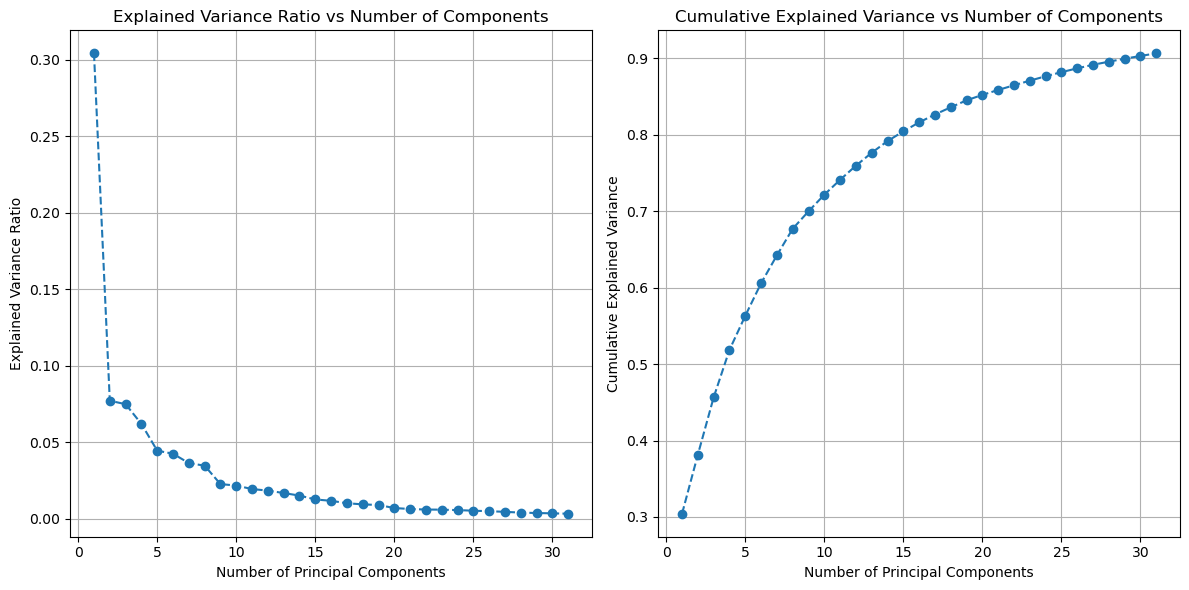

In [15]:
# screen plot

plt.figure(figsize=(12, 6))

# Plot explained variance ratio
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Components')
plt.grid(True)

# Plot cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.grid(True)

plt.tight_layout()
plt.show()

- The above plot shows that we should still increase the number of components for PCA

- However, it shows with **31** cluster we can retain **90%** of varinace in data. 

- Note that, when we want to reconstruct the original data, we shouldn't scale them. 

In [ ]:


# recover the data in batches
batch_size = 10000

recovered_heatmaps = np.empty((heatmaps.shape[0], 64*64))
for i in range(0, transformed_heatmaps.shape[0], batch_size):
    batch = transformed_heatmaps[i:i+batch_size] 
    recovered_heatmaps[i:i+batch_size] = ipca.inverse_transform(batch)

- Now the kernel died, but if we compute the recovered heatmaps, then we can compute the reconstruction error as follows:

In [ ]:

# compute reconstruction error (assuming original data was scaled)
reconstruction_error = np.mean((heatmaps_scaled - recovered_heatmaps) ** 2)
print(f'Reconstruction Error: {reconstruction_error}')


In [ ]:
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Assuming heatmaps is your large dataset (491520, 64, 64) and we split it into 5 folds
folds = 5
batch_size = 10000
data_shape = heatmaps.shape[0]

# Reshape and standardize the data
heatmaps_flat = heatmaps.reshape(data_shape, -1)

# Shuffle data and split indices into 5 folds
indices = np.arange(data_shape)
np.random.shuffle(indices)
fold_size = data_shape // folds
folds_indices = [indices[i * fold_size:(i + 1) * fold_size] for i in range(folds)]

# Cross-validation loop
for fold in range(folds):
    print(f"Fold {fold + 1} / {folds}")
    
    # Separate training and test indices
    test_indices = folds_indices[fold]
    train_indices = np.concatenate([folds_indices[i] for i in range(folds) if i != fold])

    # Initialize IncrementalPCA
    n_components = 31  # Number of components you want
    ipca = IncrementalPCA(n_components=n_components)
    
    # Standardize and fit IPCA on training data (batch-wise)
    for start in range(0, len(train_indices), batch_size):
        batch_idx = train_indices[start:start + batch_size]
        batch_data = heatmaps_flat[batch_idx]
        
        # Standardize batch
        scaler = StandardScaler()
        batch_data_scaled = scaler.fit_transform(batch_data)
        
        # Fit the batch into IPCA
        ipca.partial_fit(batch_data_scaled)
    
    # Transform the test data using the trained IPCA
    reconstruction_errors = []
    for start in range(0, len(test_indices), batch_size):
        batch_idx = test_indices[start:start + batch_size]
        batch_test_data = heatmaps_flat[batch_idx]
        
        # Standardize test batch
        scaler = StandardScaler()
        batch_test_scaled = scaler.fit_transform(batch_test_data)
        
        # Transform and inverse transform the test batch to compute reconstruction error
        test_transformed = ipca.transform(batch_test_scaled)
        test_reconstructed = ipca.inverse_transform(test_transformed)
        
        # Compute reconstruction error for this batch
        error = mean_squared_error(batch_test_scaled, test_reconstructed)
        reconstruction_errors.append(error)
    
    # Average reconstruction error for this fold
    mean_error = np.mean(reconstruction_errors)
    print(f"Fold {fold + 1} Reconstruction Error: {mean_error}")


#### Applying GMM on reduced heatmaps

- In GMM, we should find the right number of components. To do so we use Bayesian information metrics like **BIC** and **AIC**. 

- Note that metrics like silhuete score does not work well here. Because silhuete score does not work well for non spherical shape clusters.

- Note that below I got an error for confilicting two libraries for handeling multi-threading, that is between `libiomp` from (Intel OpenMP) and `libomp` from (LLVM OpenMP).

- When both of these libraries are loaded at the same time, they conflict because they manage multi-threading differently. 

- To solve this problem, we use **Thread Control (threadpoolctl)**: We can control which **OpenMP** library is loaded by limiting the number of threads used by each library. Use the **threadpoolctl** library to limit the **number of threads** for **MKL** or **OpenMP** libraries. 

- An alternative solution, 
  - Use **Single-Thread Execution**: As a last resort, you can force all your operations to run on a single thread, which avoids parallelism but resolves the OpenMP conflict. You can set the environment variables in your Python script to force single-thread execution:

- In summary, to solve the confilict between two OpenMP libraries (libiomp from Intel and libomp from LLVM),  which can cause issues in parallel computing environments we can try the followings:

  - **Controlling thread usage with threadpoolctl** => I tried this but it didn't work
  
    - `with threadpool_limits(limits=1, user_api='blas'):
    
            gm_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(transformed_heatmaps) for k in range(1, 11)]`
            
  - **Uninstall Conflicting Libraries**: You can try to resolve the conflict by making sure only one version of OpenMP is used 
    
    - conda list | grep openmp
    - conda remove llvm-openmp 
    
  - **Set Environment Variables:** Another option is to set environment variables to enforce the use of only one OpenMP library. You can try setting environment variables to limit the number of threads used: => I didn't try this
  
    - export OMP_NUM_THREADS=1
    - export MKL_NUM_THREADS=1
    
  - **Use Single-Thread Execution:** As a last resort, you can force all your operations to run on a single thread, which avoids parallelism but resolves the OpenMP conflict. You can set the environment variables in your Python script to force single-thread execution: => I tried this and it worked 
  
    - os.environ["OMP_NUM_THREADS"] = "1"
    - os.environ["MKL_NUM_THREADS"] = "1"

- I stopped this because the execution took a lot of time 

In [ ]:
from sklearn.mixture import GaussianMixture

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"


gm_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(transformed_heatmaps) for k in range(1, 11)]

### Using 3 Clusters 

In [12]:
from sklearn.mixture import GaussianMixture

- Let's apply GMM on scaled_heatmaps that we saved using 31 principal components.

In [9]:
exp = 4

seed = 42

latentvar = 'shape' 

latentcls = str([1,2])

In [10]:
root_dir = Path('/dhc/home/masoumeh.javanbakhat/netstore-old/Baysian/3D')

heatmap_embed_dir = root_dir/'Explainability'/'Codes'/'heatmap_embeddings'

heatmap_pca_31 = np.load(os.path.join(heatmap_embed_dir,f'{seed}_{exp}_shape_[1,2]_pca_31_heatmap_red_scaled.npy'))

In [14]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [15]:
# let's use 3 clusters 

gm3 = GaussianMixture(n_components=3, n_init=10, random_state=42)

gm3.fit(heatmap_pca_31)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [17]:
## let's look at bic  
bic3 = gm3.bic(heatmap_pca_31)

print(bic3)

76769190.76742528


In [18]:
## let's look at aic
aic3 = gm3.aic(heatmap_pca_31)

print(aic3)

76751611.14415455


In [19]:
## let's look at weights

gm3_weights = gm3.weights_

print(gm3_weights)

[0.41339758 0.29622606 0.29037636]


In [20]:
## let's look at means
gm3_means = gm3.means_

print(gm3_means.shape)

(3, 31)


In [21]:
## let's look at covarinaces 

gm3_cov = gm3.covariances_

print(gm3_cov.shape)

(3, 31, 31)


In [22]:
## to see if gm3 converged 
gm3.converged_


True

In [23]:
gm3_iter = gm3.n_iter_

print(gm3_iter)

28


In [25]:
# making hard clustering on clustering

gm3_hard = gm3.predict(heatmap_pca_31)

print(gm3_hard.shape)

(491520,)


In [26]:
# making soft clustering

gm3_soft = gm3.predict_proba(heatmap_pca_31)

print(gm3_soft.shape)

(491520, 3)


### Using 2 Clusters 

- Now, we apply GMM with two clusters on heatmaps. 

In [27]:
# let's use 2 clusters 

gm2 = GaussianMixture(n_components=2, n_init=10, random_state=42)

gm2.fit(heatmap_pca_31)

GaussianMixture(n_components=2, n_init=10, random_state=42)

In [28]:
gm2.converged_

True

In [29]:
gm2.n_init

10

In [30]:
aic2 = gm2.aic(heatmap_pca_31)

print(aic2)

86735325.80135883


In [31]:
bic2 = gm2.bic(heatmap_pca_31)

print(bic2)

86747041.84845336


In [35]:
gm2_hard = gm2.predict(heatmap_pca_31)

In [36]:
print(gm2_hard.shape)

(491520,)


- Computing two metrics **Calinski-Harabasz index** and **Davis-Bouldin index** on these two clustering. 

In [38]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Compute metrics on the reduced data
ch_score_reduced_gmm2 = calinski_harabasz_score(heatmap_pca_31, gm2_hard)
db_score_reduced_gmm2 = davies_bouldin_score(heatmap_pca_31, gm2_hard)

print(f'Calinski-Harabasz Index (reduced data): {ch_score_reduced_gmm2}')
print(f'Davies-Bouldin Index (reduced data): {db_score_reduced_gmm2}')

Calinski-Harabasz Index (reduced data): 24728.535129297663
Davies-Bouldin Index (reduced data): 3.8379267959565606


In [39]:
# Compute metrics on the reduced data
ch_score_reduced_gmm3 = calinski_harabasz_score(heatmap_pca_31, gm3_hard)
db_score_reduced_gmm3 = davies_bouldin_score(heatmap_pca_31, gm3_hard)

print(f'Calinski-Harabasz Index (reduced data): {ch_score_reduced_gmm3}')
print(f'Davies-Bouldin Index (reduced data): {db_score_reduced_gmm3}')

Calinski-Harabasz Index (reduced data): 22206.406447123365
Davies-Bouldin Index (reduced data): 3.432552046267894


- In terms of above metrics, we can say that the **higher Calinski-Harabasz Index** indicates better clustering, and also a **lower Davies-Bouldin Index** indicates the better clustering. 

- Visualisation indicates 3 clusters are better than 2 clusters. 

### Using 4 clusters


In [ ]:
gm4 = GaussianMixture(n_components=4, n_init=10, random_state=42)

gm4.fit(transformed_heatmaps)

### Visualise clusters for GMM with 3 clusters

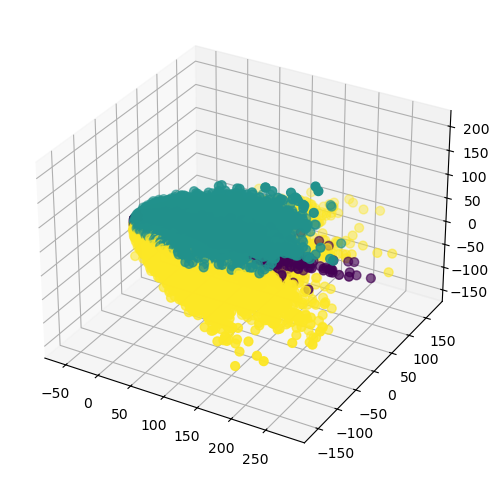

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse

X = heatmap_pca_31


labels = gm3_hard

# Step 3: Plot the 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, s=40, cmap='viridis')

- The below code gave me an error on mismatche dimension, when I tried to run this.

In [ ]:
# Step 4: Plot ellipsoids representing the Gaussian components in 3D
def draw_ellipsoid(mean, cov, ax, **kwargs):
    """ Draw an ellipsoid to represent the covariance matrix in 3D """
    # Get the eigenvalues and eigenvectors (principal axes)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Sort eigenvalues and corresponding eigenvectors in descending order
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    
    # Create grid for plotting ellipsoid
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    
    # Scale the unit sphere to the ellipsoid
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i, j], y[i, j], z[i, j]] = np.dot(np.diag(np.sqrt(eigenvalues)), [x[i, j], y[i, j], z[i, j]])
    
    # Rotate the ellipsoid to match covariance direction
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i, j], y[i, j], z[i, j]] = np.dot(eigenvectors, [x[i, j], y[i, j], z[i, j]]) + mean
    
    ax.plot_surface(x, y, z, rstride=4, cstride=4, color='black', alpha=0.2, **kwargs)

# Add ellipsoids for each Gaussian component
for mean, cov in zip(gm3.means_, gm3.covariances_):
    draw_ellipsoid(mean, cov, ax)

# Show the plot
ax.set_title('3D Visualization of GMM Clusters with 3 Components')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.show()

In [34]:
for mean, cov in zip(gm3.means_, gm3.covariances_):
    
    print(mean.shape)
    
    print(cov.shape)

(31,)
(31, 31)
(31,)
(31, 31)
(31,)
(31, 31)


### Visualise clusters for GMM with 2 clusters

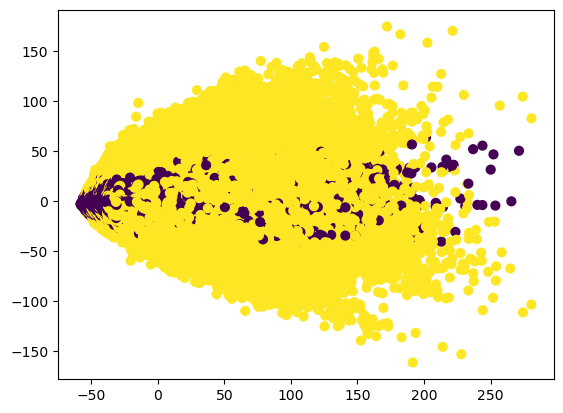

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from matplotlib.patches import Ellipse

# Step 1: Generate synthetic data with 2 clusters
X = heatmap_pca_31

# Step 2: Fit GMM with 2 components

labels = gm2_hard

# Step 3: Scatter plot of the data points colored by their cluster
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

- Clusters do not make sense at all.

In [ ]:
# Step 4: Plot the Gaussian components (ellipses)
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """ Draw an ellipse representing the covariance matrix of a Gaussian component """
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        eigenvalues, eigenvectors = np.linalg.eigh(covariance)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the ellipse
    ellip = Ellipse(position, width, height, angle, **kwargs)
    ax.add_patch(ellip)

# Add ellipses for each Gaussian component
ax = plt.gca()
for mean, cov in zip(gmm.means_, gmm.covariances_):
    draw_ellipse(mean, cov, ax=ax, alpha=0.2, color='black')

# Show the plot
plt.title('2D Visualization of GMM Clusters with 2 Components')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Applying GMM on embedded Heatmaps 

In [15]:
from sklearn.mixture import GaussianMixture

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [8]:
root_dir = Path('/dhc/home/masoumeh.javanbakhat/netstore-old/Baysian/3D')

heatmap_embed_dir = root_dir/'Explainability'/'Codes'/'heatmap_embeddings'

In [23]:
exp = 4

seed = 42

latentvar = 'shape' 

latentcls = str([1,2])

embed_net = 'sup-res18'

dimension = 50



In [24]:
# upload heatmaps that we embed using CNN

heatmap_embed = np.load(
        os.path.join(heatmap_embed_dir,f'{seed}_{exp}_{latentvar}_{latentcls}_{embed_net}_{dimension}_heatmap_embed.npy'))

In [ ]:

# Now we apply GMM with 2 clusters

gm2 = GaussianMixture(n_components=2, n_init=10, random_state=42)

gm2.fit(heatmap_embed_scaled)

In [17]:
gm2.converged_

True

In [18]:
gm2.n_init

10

In [19]:
aic2 = gm2.aic(heatmap_embed_scaled)

print(aic2)

-11141693.876868768


In [20]:
bic2 = gm2.bic(heatmap_embed_scaled)

print(bic2)

-11112253.83815068


In [21]:
gm2_hard = gm2.predict(heatmap_embed_scaled)

- **wird observation**: When I normalise heatmaps I obtained negative value for aic and bic?



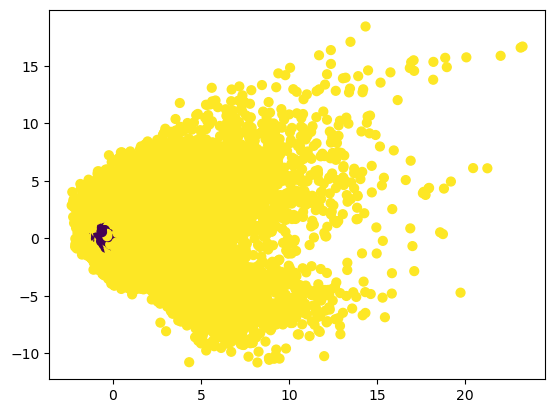

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from matplotlib.patches import Ellipse

# Step 1: Generate synthetic data with 2 clusters
X = heatmap_embed_scaled

# Step 2: Fit GMM with 2 components

labels = gm2_hard

# Step 3: Scatter plot of the data points colored by their cluster
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

- Now, let's apply GMM with **3** clusters.

- Note that when number of clusters is equal to 2, we used normalised heatmaps.

- But when the numberof clusters are 3, we didn't normalaise the heatmaps. 

- When I performed pca and then applied GMM, I got more meaningful clusters than when I used CNN and then applied GMM. 

In [26]:

# Now we apply GMM with 3 clusters

gm3 = GaussianMixture(n_components=3, n_init=10, random_state=42)

gm3.fit(heatmap_embed)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [27]:
## let's look at bic  
bic3 = gm3.bic(heatmap_embed)

print(bic3)

-204261494.35891256


In [28]:
## let's look at aic
aic3 = gm3.aic(heatmap_embed)

print(aic3)

-204305659.96961865


In [29]:
## let's look at weights

gm3_weights = gm3.weights_

print(gm3_weights)

[0.32099648 0.54000002 0.1390035 ]


In [30]:
## let's look at means
gm3_means = gm3.means_

print(gm3_means.shape)

(3, 50)


In [31]:
## to see if gm3 converged 
gm3.converged_


True

In [32]:
gm3_iter = gm3.n_iter_

print(gm3_iter)

35


In [33]:
# making hard clustering on clustering

gm3_hard = gm3.predict(heatmap_embed)

print(gm3_hard.shape)

(491520,)


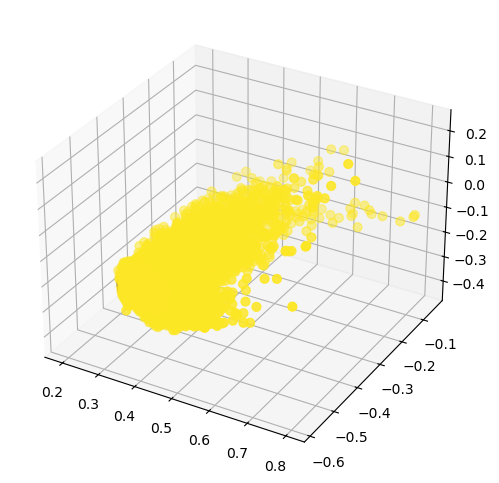

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse

X = heatmap_embed


labels = gm3_hard

# Step 3: Plot the 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, s=40, cmap='viridis')

## Visualising components of a GMM

Yes, you can **visualize the number of clusters** in a **Gaussian Mixture Model (GMM)** when the number of clusters is set to 2 or 3, especially when working with data in **two or three dimensions**. Here's how and why:

### **1. Visualization in 2D or 3D Spaces**

- **Scatter Plots:** For datasets with two or three features, you can create scatter plots where each data point is colored based on its assigned cluster. This provides a straightforward way to see how the data is partitioned.

    ![GMM 2D Visualization](https://i.imgur.com/yourimage.png) *(Replace with an actual image if needed)*

- **Gaussian Components Representation:** GMM assumes that the data is generated from a mixture of several Gaussian distributions. You can visualize each Gaussian component by plotting **ellipses** (in 2D) or **ellipsoids** (in 3D) that represent the covariance of each cluster. These shapes help illustrate the spread and orientation of each Gaussian distribution.

    - **Mean:** The center of each ellipse/ellipsoid corresponds to the mean of the Gaussian component.
    - **Covariance:** The shape and size reflect the covariance matrix, indicating how the data is dispersed around the mean.

### **2. Dimensionality Reduction for Higher-Dimensional Data**

If your data has more than three dimensions, direct visualization becomes challenging. In such cases, you can apply **dimensionality reduction techniques** before visualization:

- **Principal Component Analysis (PCA):** Reduces the data to the most significant principal components, capturing the majority of the variance.
  
- **t-Distributed Stochastic Neighbor Embedding (t-SNE):** Useful for visualizing high-dimensional data by preserving local structures.

- **Uniform Manifold Approximation and Projection (UMAP):** Another technique for dimensionality reduction that preserves both local and global data structures.

After reducing the dimensions, you can create 2D or 3D plots similar to those described above.

### **3. Tools and Libraries**

Several programming libraries can assist with visualizing GMM clusters:

- **Python's `matplotlib` and `seaborn`:** For creating detailed and customizable plots.
  
- **`scikit-learn`:** Provides built-in functions for fitting GMMs and accessing the parameters needed for visualization.

- **`plotly`:** For interactive visualizations, which can be particularly helpful for exploring data.

### **5. Considerations**

- **Choice of Number of Clusters (`n_components`):** While visualization can help interpret clusters, selecting the optimal number of clusters often involves metrics like **AIC (Akaike Information Criterion)** or **BIC (Bayesian Information Criterion)**.

- **Covariance Type:** GMM allows different covariance structures (e.g., spherical, diagonal, full). The choice affects the shape of the Gaussian components and thus the visualization.

- **Overlapping Clusters:** In cases where clusters overlap significantly, visualization can help assess the clarity of separation but may also reveal limitations in clustering performance.

### **Conclusion**

Visualizing GMM clusters when the number of clusters is 2 or 3 is not only possible but also a powerful way to understand the underlying structure of your data. Whether working in low-dimensional spaces or applying dimensionality reduction techniques for higher-dimensional data, visualization aids in interpreting the model's clustering results and in making informed decisions about the suitability of the chosen number of clusters.

### Looking at distribution of features

In [3]:
root_dir = Path('/dhc/home/masoumeh.javanbakhat/netstore-old/Baysian/3D')

heatmap_dir = root_dir/'Explainability'/'Codes'/'heatmaps'

In [4]:
exp = 4

seed = 42

latentvar = 'shape' 

latentcls = str([1,2])

In [5]:
heatmaps = np.load(os.path.join(heatmap_dir,
                          f'{exp}_{seed}_{latentvar}_{latentcls}_htm.npy'))

In [6]:
print(heatmaps.shape)

(491520, 64, 64)


In [11]:
mid_point = 491520 // 2

print(mid_point)

group1_features = heatmaps[:mid_point]
group2_features = heatmaps[mid_point:]

print(group1_features.shape)

print(group2_features.shape)

245760
(245760, 64, 64)
(245760, 64, 64)


In [12]:
def process_in_batches(heatmaps, batch_size):

    heatmaps_flatten = np.empty((heatmaps.shape[0], 64*64))
    n_samples = heatmaps.shape[0]

    for i in range(0, heatmaps.shape[0], batch_size):
        print(f'batch_idx:{i}\n')
        end_index = min(i + batch_size, n_samples)
        batch = heatmaps[i:end_index].reshape(-1, 64*64)
        heatmaps_flatten[i:end_index] = batch 
    
    print(heatmaps_flatten.shape)
    

In [ ]:
group1_flattened = process_in_batches(group1_features, batch_size=10000)

batch_idx:0

batch_idx:10000

batch_idx:20000

batch_idx:30000

batch_idx:40000

batch_idx:50000

batch_idx:60000

batch_idx:70000

batch_idx:80000

batch_idx:90000

batch_idx:100000

batch_idx:110000

batch_idx:120000

batch_idx:130000

batch_idx:140000

batch_idx:150000

batch_idx:160000

batch_idx:170000

batch_idx:180000

batch_idx:190000

batch_idx:200000



In [1]:
mid_point = 491520 // 2

print(mid_point)

245760


In [8]:
import numpy as np

exp=4
seed = 42
latentvar = 'shape'
latentcls = str([1,2])


def process_in_batches(heatmaps, batch_size):
    root_dir = Path('/dhc/home/masoumeh.javanbakhat/netstore-old/Baysian/3D')
    heatmap_dir = root_dir/'Explainability'/'Codes'/'heatmaps'
    
    np.load(os.path.join(heatmap_dir,
                          f'{exp}_{seed}_{latentvar}_{latentcls}_htm.npy'))
    
    
    n_samples = heatmaps.shape[0]
    flattened_shape = 64 * 64
    batch_files = []

    # Process in batches and save each batch as a separate file
    for i in range(0, n_samples, batch_size):
        print(f'Processing batch starting at index {i}')
        end_index = min(i + batch_size, n_samples)
        batch = heatmaps[i:end_index].reshape(-1, flattened_shape)
        
        # Save each batch to a separate file
        batch_file = os.path.join(heatmap_dir,f'{exp}_{seed}_{latentvar}_{latentcls}_flatten_batch_{i // batch_size}.npy')
        np.save(batch_file, batch)
        batch_files.append(batch_file)

    # Load and concatenate all the batches into one large array
    all_batches = []
    for batch_file in batch_files:
        batch = np.load(batch_file)
        all_batches.append(batch)
    
    # Concatenate all batches into a single array
    full_array = np.vstack(all_batches)
    
    # Save the full array as a single file
    np.save(os.path.join(heatmap_dir,f'{exp}_{seed}_{latentvar}_{latentcls}_flatten_heat.npy'), full_array)

    print(f'Full array saved!')


In [ ]:
process_in_batches(heatmaps, batch_size=10000)

### Testing DeepTwoSampleTest

In [ ]:
%run ./Clustering.py

In [1]:
for i in range(2,3):
    
    print(i)

2
